In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from net import Net
import random
import sys
import numpy as np

In [2]:
import sys
print(sys.executable)

/home/zliu/anaconda3/envs/myenv/bin/python


In [3]:
import copy

In [4]:
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        #print(loss.item())
    return loss.item()

def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    acc = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    acc=100. * correct / len(test_loader.dataset);
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        acc))
    return acc

In [5]:
x=datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))]))

In [6]:
x.train_labels

/home/zliu/anaconda3/envs/myenv/lib/python3.6/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


tensor([5, 0, 4,  ..., 5, 6, 8])

In [7]:
ran=[i for i in range(0,60000)]
random.seed(42)
index=random.sample(ran,int(60000*0.8))

In [8]:
index_yes=[x for x in range(60000) if x not in index]

[41905,
 7296,
 1639,
 48598,
 18024,
 16049,
 14628,
 9144,
 48265,
 6717,
 44348,
 48540,
 58469,
 35741,
 5697,
 38698,
 27651,
 2082,
 1952,
 6140,
 14328,
 15247,
 33118,
 39453,
 1739,
 36781,
 13031,
 46925,
 42590,
 45962,
 35713,
 27493,
 14446,
 29439,
 38618,
 18231,
 53046,
 56970,
 425,
 49729,
 52810,
 10463,
 45753,
 27696,
 22298,
 18210,
 10189,
 14110,
 50036,
 22059,
 6698,
 6078,
 24898,
 6338,
 23526,
 55541,
 22541,
 39565,
 17335,
 52895,
 2847,
 47823,
 30108,
 35142,
 8180,
 24807,
 5164,
 36178,
 19213,
 54355,
 41198,
 40535,
 58028,
 56472,
 23700,
 37837,
 12601,
 46174,
 4558,
 3003,
 43336,
 14935,
 50663,
 18965,
 5229,
 56054,
 15256,
 56785,
 6619,
 24911,
 18217,
 29714,
 41660,
 54664,
 23909,
 10659,
 24260,
 23283,
 13730,
 43920,
 17496,
 45994,
 44796,
 42469,
 4679,
 39920,
 41613,
 11215,
 35005,
 47784,
 16043,
 10708,
 30294,
 24867,
 17691,
 41943,
 45099,
 36500,
 14392,
 44866,
 21252,
 55237,
 50352,
 50855,
 3665,
 15010,
 53857,
 2103,


In [13]:
x_origin=copy.deepcopy(x.train_labels.numpy())

In [14]:
x.train_labels[index]=x.train_labels[index].random_(0,10)
x.train_labels

tensor([7, 0, 5,  ..., 5, 3, 4])

In [15]:
(x_origin==x.train_labels.numpy()).sum()

16795

In [26]:
x_corrupt=[x[i] for i in index]

In [27]:
x_pure=[x[i] for i in index_yes]

48000 12000


In [12]:
def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=600, metavar='N',
                        help='input batch size for training (default: 256)')
    parser.add_argument('--test-batch-size', type=int, default=4000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=100, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.005, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                        help='how many batches to wait before logging training status')
    
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")
     
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        x,
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)
#     train_loader=x

    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

    acc=[]
    loss=[]
    for epoch in range(1, args.epochs + 1):
        loss.append(train(args, model, device, train_loader, optimizer, epoch))
        acc.append(test(args, model, device, test_loader))
    np.save("acc.npy",acc)
    np.save("loss.npy",loss)
    if (args.save_model):
        torch.save(model.state_dict(),"mnist_cnn.pt")

In [57]:
sys.argv = ['-f']
main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.310410

Test set: Average loss: 1.9441, Accuracy: 7081/10000 (71%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.249251

Test set: Average loss: 1.6912, Accuracy: 8529/10000 (85%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.224187

Test set: Average loss: 1.6350, Accuracy: 8544/10000 (85%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.218054

Test set: Average loss: 1.5886, Accuracy: 9023/10000 (90%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.222502

Test set: Average loss: 1.5434, Accuracy: 9054/10000 (91%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 2.233694

Test set: Average loss: 1.5222, Accuracy: 9232/10000 (92%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 2.207226

Test set: Average loss: 1.4668, Accuracy: 9354/10000 (94%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 2.208597

Test set: Average loss: 1.4863, Accuracy: 9378/10000 (94%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 2.188291

Test set: Average loss: 1.4735, Accuracy: 9390/10000 (94%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 2.193604


Train Epoch: 78 [0/60000 (0%)]	Loss: 1.812100

Test set: Average loss: 1.4697, Accuracy: 5708/10000 (57%)

Train Epoch: 79 [0/60000 (0%)]	Loss: 1.873515

Test set: Average loss: 1.5803, Accuracy: 5296/10000 (53%)

Train Epoch: 80 [0/60000 (0%)]	Loss: 1.806743

Test set: Average loss: 1.5054, Accuracy: 5604/10000 (56%)

Train Epoch: 81 [0/60000 (0%)]	Loss: 1.809042

Test set: Average loss: 1.5328, Accuracy: 5540/10000 (55%)

Train Epoch: 82 [0/60000 (0%)]	Loss: 1.765912

Test set: Average loss: 1.5154, Accuracy: 5660/10000 (57%)

Train Epoch: 83 [0/60000 (0%)]	Loss: 1.741782

Test set: Average loss: 1.5961, Accuracy: 4822/10000 (48%)

Train Epoch: 84 [0/60000 (0%)]	Loss: 1.777798

Test set: Average loss: 1.5521, Accuracy: 5056/10000 (51%)

Train Epoch: 85 [0/60000 (0%)]	Loss: 1.764060

Test set: Average loss: 1.6048, Accuracy: 4982/10000 (50%)

Train Epoch: 86 [0/60000 (0%)]	Loss: 1.666512

Test set: Average loss: 1.5261, Accuracy: 5339/10000 (53%)

Train Epoch: 87 [0/60000 (0%)]	Loss: 

In [58]:
acc=np.load("acc.npy")
x_axis=np.arange(100)
loss=np.load("loss.npy")
loss

array([2.25822425, 2.23524666, 2.21768546, 2.22186112, 2.20081496,
       2.20428395, 2.1731472 , 2.19734979, 2.20998096, 2.17323923,
       2.1650281 , 2.21471596, 2.1842258 , 2.16076207, 2.16489697,
       2.1933074 , 2.17973065, 2.14636397, 2.171031  , 2.15407968,
       2.1687777 , 2.1690402 , 2.19231343, 2.15574574, 2.19541717,
       2.19620657, 2.14515948, 2.16952682, 2.11066484, 2.1471467 ,
       2.15452385, 2.14884949, 2.13569498, 2.19627833, 2.16927433,
       2.14574099, 2.1309166 , 2.15185618, 2.10642767, 2.0988698 ,
       2.13644004, 2.12877369, 2.11211467, 2.13259268, 2.09419513,
       2.13122511, 2.13611722, 2.1040132 , 2.03548145, 2.09505892,
       2.08965349, 2.05152154, 2.10330367, 2.12885118, 2.03895426,
       2.07668996, 2.10448408, 2.05530763, 2.04604006, 2.06115389,
       2.09637928, 2.08609366, 2.01493692, 1.97022355, 2.01340818,
       1.9488591 , 1.99540734, 2.02036977, 2.0035913 , 1.96987343,
       1.88938677, 1.9226023 , 1.9526099 , 1.97372544, 1.90596

In [35]:
import matplotlib.pyplot as plt

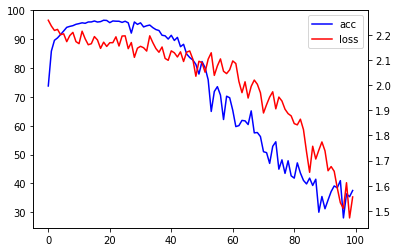

In [84]:
# fig,left_axis=plt.subplots()
# right_axis = left_axis.twinx()

# p1, = left_axis.plot(x_axis,p,color='blue',label="acc")
# p2, = right_axis.plot(x_axis,loss,color='red',label="loss")
# plt.title("result")
# plt.legend(loc="best")
fig = plt.figure()
ax = fig.add_subplot(111)
f1=ax.plot(x_axis,p,color='blue',label="acc")
ax2 = ax.twinx()
f2=ax2.plot(x_axis,loss,color='red',label="loss")
f=f1+f2
labs = [l.get_label() for l in f]
ax.legend(f, labs, loc=0)


In [29]:
def main_corrupt_set():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=600, metavar='N',
                        help='input batch size for training (default: 256)')
    parser.add_argument('--test-batch-size', type=int, default=4000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=100, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.005, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                        help='how many batches to wait before logging training status')
    
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")
     
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        x_corrupt,
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)
#     train_loader=x

    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

    acc=[]
    loss=[]
    for epoch in range(1, args.epochs + 1):
        loss.append(train(args, model, device, train_loader, optimizer, epoch))
        acc.append(test(args, model, device, test_loader))
    np.save("acc_corrupt.npy",acc)
    np.save("loss_corrupt.npy",loss)
    if (args.save_model):
        torch.save(model.state_dict(),"mnist_cnn.pt")

In [30]:
sys.argv = ['-f']
main_corrupt_set()

Train Epoch: 1 [0/48000 (0%)]	Loss: 2.306429

Test set: Average loss: 2.3048, Accuracy: 1410/10000 (14%)

Train Epoch: 2 [0/48000 (0%)]	Loss: 2.305572

Test set: Average loss: 2.3086, Accuracy: 728/10000 (7%)

Train Epoch: 3 [0/48000 (0%)]	Loss: 2.303655

Test set: Average loss: 2.3078, Accuracy: 523/10000 (5%)

Train Epoch: 4 [0/48000 (0%)]	Loss: 2.303049

Test set: Average loss: 2.3078, Accuracy: 785/10000 (8%)

Train Epoch: 5 [0/48000 (0%)]	Loss: 2.300982

Test set: Average loss: 2.3094, Accuracy: 718/10000 (7%)

Train Epoch: 6 [0/48000 (0%)]	Loss: 2.300130

Test set: Average loss: 2.3100, Accuracy: 735/10000 (7%)

Train Epoch: 7 [0/48000 (0%)]	Loss: 2.302365

Test set: Average loss: 2.3112, Accuracy: 537/10000 (5%)

Train Epoch: 8 [0/48000 (0%)]	Loss: 2.298528

Test set: Average loss: 2.3129, Accuracy: 516/10000 (5%)

Train Epoch: 9 [0/48000 (0%)]	Loss: 2.298155

Test set: Average loss: 2.3131, Accuracy: 560/10000 (6%)

Train Epoch: 10 [0/48000 (0%)]	Loss: 2.301642

Test set: Avera

Train Epoch: 79 [0/48000 (0%)]	Loss: 2.116740

Test set: Average loss: 2.3874, Accuracy: 1271/10000 (13%)

Train Epoch: 80 [0/48000 (0%)]	Loss: 2.082866

Test set: Average loss: 2.4228, Accuracy: 1115/10000 (11%)

Train Epoch: 81 [0/48000 (0%)]	Loss: 2.084755

Test set: Average loss: 2.4683, Accuracy: 1087/10000 (11%)

Train Epoch: 82 [0/48000 (0%)]	Loss: 2.105351

Test set: Average loss: 2.4413, Accuracy: 1064/10000 (11%)

Train Epoch: 83 [0/48000 (0%)]	Loss: 2.047832

Test set: Average loss: 2.5392, Accuracy: 910/10000 (9%)

Train Epoch: 84 [0/48000 (0%)]	Loss: 2.121968

Test set: Average loss: 2.5005, Accuracy: 1011/10000 (10%)

Train Epoch: 85 [0/48000 (0%)]	Loss: 2.044737

Test set: Average loss: 2.4623, Accuracy: 1069/10000 (11%)

Train Epoch: 86 [0/48000 (0%)]	Loss: 2.064298

Test set: Average loss: 2.4307, Accuracy: 1200/10000 (12%)

Train Epoch: 87 [0/48000 (0%)]	Loss: 2.022727

Test set: Average loss: 2.5404, Accuracy: 980/10000 (10%)

Train Epoch: 88 [0/48000 (0%)]	Loss: 2.0

In [31]:
def main_pure_set():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=600, metavar='N',
                        help='input batch size for training (default: 256)')
    parser.add_argument('--test-batch-size', type=int, default=4000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=100, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.005, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                        help='how many batches to wait before logging training status')
    
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")
     
    kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        x_pure,
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)
#     train_loader=x

    model = Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

    acc=[]
    loss=[]
    for epoch in range(1, args.epochs + 1):
        loss.append(train(args, model, device, train_loader, optimizer, epoch))
        acc.append(test(args, model, device, test_loader))
    np.save("acc_pure.npy",acc)
    np.save("loss_pure.npy",loss)
    if (args.save_model):
        torch.save(model.state_dict(),"mnist_cnn.pt")

In [32]:
sys.argv = ['-f']
main_pure_set()

Train Epoch: 1 [0/12000 (0%)]	Loss: 2.303364

Test set: Average loss: 2.0628, Accuracy: 5873/10000 (59%)

Train Epoch: 2 [0/12000 (0%)]	Loss: 2.055946

Test set: Average loss: 0.9533, Accuracy: 7633/10000 (76%)

Train Epoch: 3 [0/12000 (0%)]	Loss: 0.952204

Test set: Average loss: 0.4601, Accuracy: 8569/10000 (86%)

Train Epoch: 4 [0/12000 (0%)]	Loss: 0.511371

Test set: Average loss: 0.3522, Accuracy: 8895/10000 (89%)

Train Epoch: 5 [0/12000 (0%)]	Loss: 0.374803

Test set: Average loss: 0.2909, Accuracy: 9141/10000 (91%)

Train Epoch: 6 [0/12000 (0%)]	Loss: 0.297305

Test set: Average loss: 0.2577, Accuracy: 9228/10000 (92%)

Train Epoch: 7 [0/12000 (0%)]	Loss: 0.254769

Test set: Average loss: 0.2295, Accuracy: 9326/10000 (93%)

Train Epoch: 8 [0/12000 (0%)]	Loss: 0.277708

Test set: Average loss: 0.2042, Accuracy: 9401/10000 (94%)

Train Epoch: 9 [0/12000 (0%)]	Loss: 0.232820

Test set: Average loss: 0.1930, Accuracy: 9442/10000 (94%)

Train Epoch: 10 [0/12000 (0%)]	Loss: 0.190357


Train Epoch: 78 [0/12000 (0%)]	Loss: 0.012835

Test set: Average loss: 0.0564, Accuracy: 9838/10000 (98%)

Train Epoch: 79 [0/12000 (0%)]	Loss: 0.006972

Test set: Average loss: 0.0554, Accuracy: 9828/10000 (98%)

Train Epoch: 80 [0/12000 (0%)]	Loss: 0.010158

Test set: Average loss: 0.0559, Accuracy: 9832/10000 (98%)

Train Epoch: 81 [0/12000 (0%)]	Loss: 0.009549

Test set: Average loss: 0.0557, Accuracy: 9829/10000 (98%)

Train Epoch: 82 [0/12000 (0%)]	Loss: 0.007927

Test set: Average loss: 0.0539, Accuracy: 9828/10000 (98%)

Train Epoch: 83 [0/12000 (0%)]	Loss: 0.009585

Test set: Average loss: 0.0552, Accuracy: 9829/10000 (98%)

Train Epoch: 84 [0/12000 (0%)]	Loss: 0.011731

Test set: Average loss: 0.0544, Accuracy: 9831/10000 (98%)

Train Epoch: 85 [0/12000 (0%)]	Loss: 0.008095

Test set: Average loss: 0.0545, Accuracy: 9822/10000 (98%)

Train Epoch: 86 [0/12000 (0%)]	Loss: 0.007812

Test set: Average loss: 0.0545, Accuracy: 9832/10000 (98%)

Train Epoch: 87 [0/12000 (0%)]	Loss: 

In [33]:
acc=np.load("acc.npy")
x_axis=np.arange(100)
loss=np.load("loss.npy")
loss_corrupt=np.load("loss_corrupt.npy")
loss_pure=np.load("loss_pure.npy")

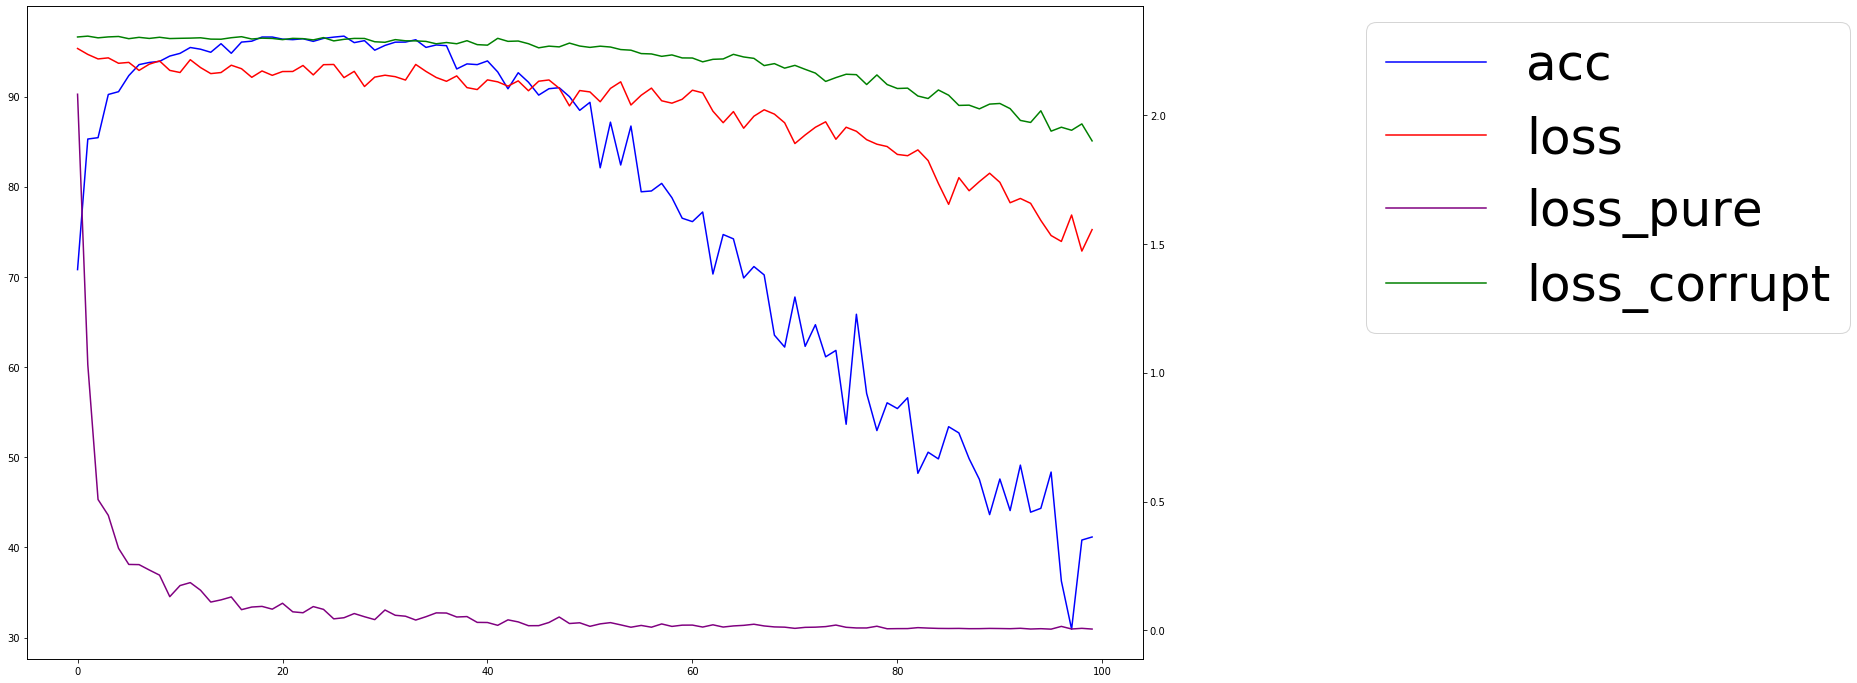

In [56]:
fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)
f1=ax.plot(x_axis,acc,color='blue',label="acc")
ax2 = ax.twinx()
f2=ax2.plot(x_axis,loss,color='red',label="loss")
f3=ax2.plot(x_axis,loss_pure,color='purple',label="loss_pure")
f4=ax2.plot(x_axis,loss_corrupt,color='green',label="loss_corrupt")
f=f1+f2+f3+f4
labs = [l.get_label() for l in f]
ax.legend(f, labs, loc=[1.2, 0.5],prop={'size': 50})